In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kritanjalijain/fashion-anchor-cloth-pairs")

print("Path to dataset files:", path)

100%|██████████| 14.3G/14.3G [01:57<00:00, 131MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kritanjalijain/fashion-anchor-cloth-pairs/versions/5


In [2]:
# in a Kaggle notebook code cell
!find /kaggle/input/fashion-anchor-cloth-pairs -maxdepth 3 -type d | sed 's#/kaggle/input/fashion-anchor-cloth-pairs/##'


find: ‘/kaggle/input/fashion-anchor-cloth-pairs’: No such file or directory


In [3]:
# list all directories under the dataset
!find /kaggle/input/fashion-anchor-cloth-pairs -type d | sed 's|/kaggle/input/fashion-anchor-cloth-pairs/||'


find: ‘/kaggle/input/fashion-anchor-cloth-pairs’: No such file or directory


In [4]:
# should list "cloths" and "human"
!ls /kaggle/input/fashion-anchor-cloth-pairs/pants_dataset/pants_dataset/men_pants

# should list "cloths" and "human"
!ls /kaggle/input/fashion-anchor-cloth-pairs/upperwear_dataset/upperwear_dataset/men_top


ls: cannot access '/kaggle/input/fashion-anchor-cloth-pairs/pants_dataset/pants_dataset/men_pants': No such file or directory
ls: cannot access '/kaggle/input/fashion-anchor-cloth-pairs/upperwear_dataset/upperwear_dataset/men_top': No such file or directory


In [6]:
import os, glob

BASE = "/root/.cache/kagglehub/datasets/kritanjalijain/fashion-anchor-cloth-pairs/versions/5"

pants_cloths = os.path.join(
    BASE, "pants_dataset", "pants_dataset", "men_pants", "cloths"
)
top_cloths = os.path.join(
    BASE, "upperwear_dataset", "upperwear_dataset", "men_top", "cloths"
)

# sanity check
assert os.path.isdir(pants_cloths), f"Missing: {pants_cloths}"
assert os.path.isdir(top_cloths),   f"Missing: {top_cloths}"

# grab images
pants_imgs = glob.glob(os.path.join(pants_cloths, "*.png")) + \
             glob.glob(os.path.join(pants_cloths, "*.jpg"))
tops_imgs  = glob.glob(os.path.join(top_cloths,  "*.png")) + \
             glob.glob(os.path.join(top_cloths,  "*.jpg"))

print(f"Found {len(pants_imgs)} men-pants images in\n  {pants_cloths}")
print(f"Found {len(tops_imgs)} men-top   images in\n  {top_cloths}")

# peek
print("Sample pants:", pants_imgs[:3])
print("Sample tops: ", tops_imgs[:3])


Found 8247 men-pants images in
  /root/.cache/kagglehub/datasets/kritanjalijain/fashion-anchor-cloth-pairs/versions/5/pants_dataset/pants_dataset/men_pants/cloths
Found 10199 men-top   images in
  /root/.cache/kagglehub/datasets/kritanjalijain/fashion-anchor-cloth-pairs/versions/5/upperwear_dataset/upperwear_dataset/men_top/cloths
Sample pants: ['/root/.cache/kagglehub/datasets/kritanjalijain/fashion-anchor-cloth-pairs/versions/5/pants_dataset/pants_dataset/men_pants/cloths/menpant1864.png', '/root/.cache/kagglehub/datasets/kritanjalijain/fashion-anchor-cloth-pairs/versions/5/pants_dataset/pants_dataset/men_pants/cloths/menpant6851.png', '/root/.cache/kagglehub/datasets/kritanjalijain/fashion-anchor-cloth-pairs/versions/5/pants_dataset/pants_dataset/men_pants/cloths/menpant6153.png']
Sample tops:  ['/root/.cache/kagglehub/datasets/kritanjalijain/fashion-anchor-cloth-pairs/versions/5/upperwear_dataset/upperwear_dataset/men_top/cloths/m8943.png', '/root/.cache/kagglehub/datasets/kritanja

In [7]:
# 0) Imports
import glob, os
from sklearn.model_selection import train_test_split
from PIL import Image

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import EfficientNet_B0_Weights

# 1) Your image lists (you already have these)
# pants_imgs, tops_imgs

# 2) Build combined paths & labels
all_paths  = pants_imgs + tops_imgs
all_labels = [0]*len(pants_imgs) + [1]*len(tops_imgs)   # 0 = pants, 1 = tops

# 3) Split into train / val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

print(f"→ Training on {len(train_paths)} images, validating on {len(val_paths)}")



→ Training on 14756 images, validating on 3690


In [8]:

# 3) Split into train / val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

In [9]:
# 4) Dataset class
class UpperLowerDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths, self.labels, self.transform = paths, labels, transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [10]:
# 5) EfficientNet-B0 and its preprocessing
weights = EfficientNet_B0_Weights.DEFAULT
tf      = weights.transforms()   # includes resizing, normalization

In [11]:
# 6) Datasets & DataLoaders
train_ds = UpperLowerDataset(train_paths, train_labels, transform=tf)
val_ds   = UpperLowerDataset(val_paths,   val_labels,   transform=tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)


In [12]:
# 7) Model, loss, optimizer  – offline / no pre-trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load EfficientNet-B0 from scratch
model = models.efficientnet_b0(weights=None).to(device)

# swap out the head for 2 classes
in_feats = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_feats, 2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [13]:
# 8) Quick sanity check: one batch
imgs, labs = next(iter(train_loader))
print("Batch shapes:", imgs.shape, labs.shape)  # e.g. [32,3,224,224], [32]


Batch shapes: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [14]:
def run_epoch(loader, train=True):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.set_grad_enabled(train):
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += imgs.size(0)

    avg_loss  = epoch_loss / total
    accuracy  = correct / total
    return avg_loss, accuracy

# Now run your training loop
num_epochs = 5
for epoch in range(1, num_epochs+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)
    print(f"[Epoch {epoch}]  train_loss={tr_loss:.3f}, train_acc={tr_acc:.3f} | "
          f"val_loss={va_loss:.3f},   val_acc={va_acc:.3f}")


[Epoch 1]  train_loss=0.135, train_acc=0.946 | val_loss=0.022,   val_acc=0.992
[Epoch 2]  train_loss=0.027, train_acc=0.991 | val_loss=0.012,   val_acc=0.995
[Epoch 3]  train_loss=0.015, train_acc=0.996 | val_loss=0.008,   val_acc=0.997
[Epoch 4]  train_loss=0.015, train_acc=0.995 | val_loss=0.012,   val_acc=0.995
[Epoch 5]  train_loss=0.007, train_acc=0.998 | val_loss=0.010,   val_acc=0.996


In [24]:
from PIL import Image
import torch
from torchvision import transforms

label_map = {0: "lower", 1: "upper"}

image_path = "/test4.jpeg"  # change this to your image path

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


def predict_image(path, model, transform, device):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)
        pred = probs.argmax(dim=1).item()
        conf = probs[0][pred].item()
    return label_map[pred], conf

pred_label, confidence = predict_image(image_path, model, transform, device)
print(f"Predicted: {pred_label} ({confidence * 100:.2f}%)")


Predicted: lower (98.15%)


In [26]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

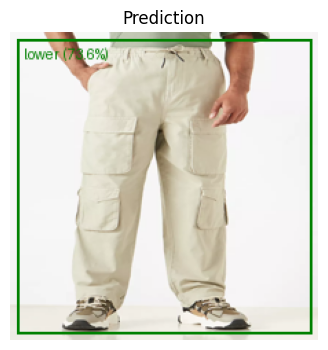

In [44]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# 1. Label map
label_map = {0: "lower", 1: "upper"}

# 2. Image path
image_path = "/test6.webp"  # change this

# 3. Preprocessing (must match your training setup)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 4. Prediction + visualization
def predict_and_show(path, model, transform, device):
    img = Image.open(image_path).convert("RGB")
    vis_img = img.copy().resize((224, 224))  # for drawing

    # Preprocess
    x = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)
        pred = probs.argmax(dim=1).item()
        conf = probs[0][pred].item()

    # Draw box and label
    draw = ImageDraw.Draw(vis_img)
    draw.rectangle([5, 5, 219, 219], outline="green", width=2)
    label_text = f"{label_map[pred]} ({conf*100:.1f}%)"
    draw.text((10, 10), label_text, fill="green")

    # Show
    plt.figure(figsize=(4, 4))
    plt.imshow(vis_img)
    plt.axis("off")
    plt.title("Prediction")
    plt.show()

# Run it
predict_and_show(image_path, model, transform, device)